In [169]:
words = open('swedish_names.txt', 'r', encoding='utf-8').read().splitlines()
words[0:10]

['A',
 'Aabo',
 'Aaby',
 'Aadam',
 'Aadan',
 'Aadel',
 'Aaden',
 'Aadolf',
 'Aagaard',
 'Aage']

In [170]:
words = [w.lower() for w in words if len(w) > 2] # Remove 2< longs words
words = [w for w in words if w.isascii() and w.isalpha()] # Remove names with åäö or that contains bad things
words[-3:]

['zilan', 'zoe', 'zuzanna']

In [171]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
sorted(b.items(), key=lambda kv: kv[1], reverse=True)[0:10]

[(('n', '<E>'), 2253),
 (('a', 'n'), 1974),
 (('<S>', 'a'), 1689),
 (('a', 'r'), 1634),
 (('r', '<E>'), 1445),
 (('e', 'r'), 1341),
 (('<S>', 's'), 1300),
 (('<S>', 'm'), 1219),
 (('h', 'a'), 1203),
 (('s', '<E>'), 1196)]

In [172]:
import torch

In [173]:
letters = sorted(list(set(''.join(words)))) # Get all individual letters sorted, should be alphabet (if all letters are once included in our names)
num_of_unique_letters = len(letters) + 1 # Add 1 for '.' our special char
stoi = {s:i+1 for i,s in enumerate(letters)} # Create a mapping from a char to a int in order to index in tensor
stoi['.'] = 0 # Add . as a special char
itos = {i:s for s,i in stoi.items()} # Create the mapping in reverse

# Create tensor and  fill it up
counts = torch.zeros((num_of_unique_letters, num_of_unique_letters), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        counts[stoi[ch1], stoi[ch2]] += 1

(-0.5, 26.5, 26.5, -0.5)

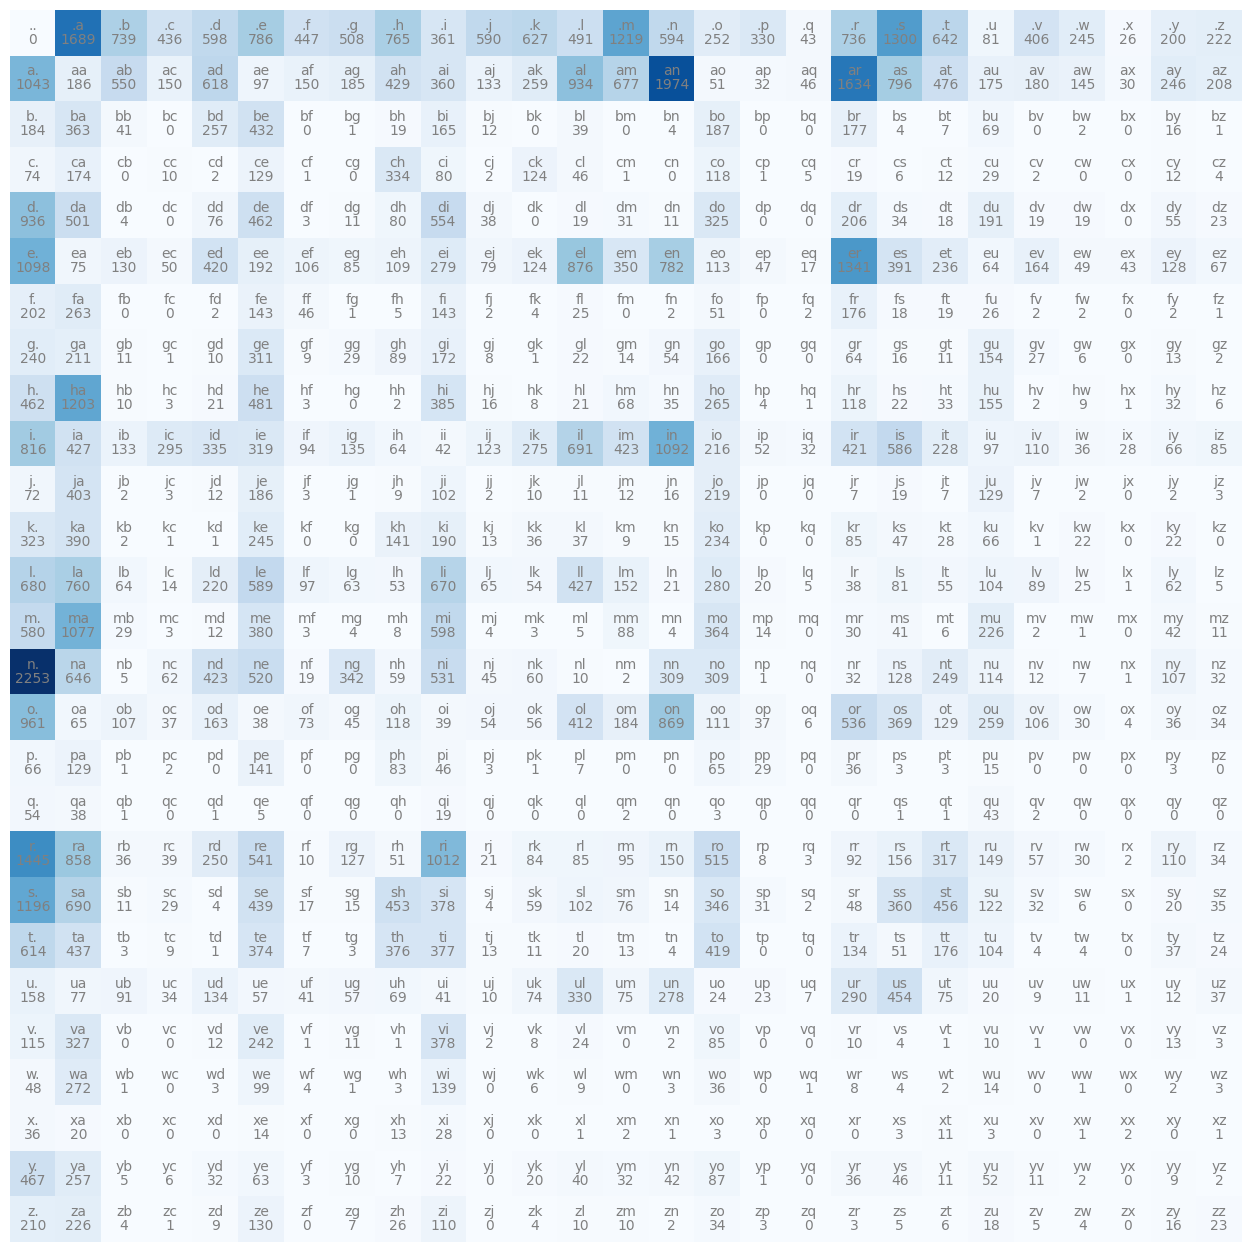

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline


# Plot a nice figure to show what words follow what
plt.figure(figsize=(16,16))
plt.imshow(counts, cmap='Blues')
for i in range(num_of_unique_letters):
    for j in range(num_of_unique_letters):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, counts[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

We apply model smoothing by doing (counts+1) in order to not achieve inf / -inf possibilities in our loss function.

In [175]:
allProbs = (counts+1).float()
allProbs /= allProbs.sum(1, keepdim=True)
g = torch.Generator().manual_seed(3)

for i in range(10):
    name = []
    idx = 0
    while True:
        probs = allProbs[idx,:]
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        name += itos[idx]
    print(''.join(name))

ahlarichar
makuabevaon
el
imero
aabr
jethaligeon
arerijojale
g
agj
zmabanyudil


We can see that the naive way of only generating names based on the counted probabilities does not seem to produce very good results.

In [176]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["rasmus"]:
    chs = ['.'] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        prob = allProbs[stoi[ch1], stoi[ch2]]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
  
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-251820.2344)
nll=tensor(251820.2344)
2.567079544067383


We can create a loss function calculating how likely our model is to predict a certain name.
If we then loop over all words in "words" and compute the loss function to then average we can compute how well our models loss.

# NN

In [177]:
import torch.nn.functional as F

In [178]:
xTrain, yTrain = [], []

for w in words:
    chs = ['.'] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        xTrain.append(stoi[ch1])
        yTrain.append(stoi[ch2])
        
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)
xTrainEnc = F.one_hot(xTrain, num_classes=num_of_unique_letters).float()
print(f'Num of training examples: {xTrain.nelement()}')

Num of training examples: 98096


In [179]:
g = torch.Generator().manual_seed(3)
W = torch.randn(num_of_unique_letters, num_of_unique_letters, requires_grad=True, generator=g)

In [180]:
for i in range(1000):
    # Forward pass
    logits = xTrainEnc @ W # (xTrain.nelement(), 27) @ (27, 27) -> (xTrain.nelement(), 27) [@ is matrix multiplication]
                           # 'log-counts' or 'logits'
    counts = logits.exp()  # Interpreted as our counts
    yPred = counts/counts.sum(1, keepdims=True) # Normalize
    loss = -yPred[torch.arange(xTrain.nelement()), yTrain].log().mean()
    #print(f'Loss at {i}: {loss:.4f}')
    
    # Backward pass
    W.grad = None # Set gradient to 0 efficiently
    loss.backward()

    # Weight update
    W.data += -10 * W.grad
print(f'Final loss: {loss:.4f}')

Final loss: 2.5732


In [181]:
g = torch.Generator().manual_seed(3)

for i in range(10):
    idx = 0
    name = []
    while True:
        # Only forward pass in order to predict, no need to change the model afterwards
        xTrainEnc = F.one_hot(torch.tensor([idx]), num_classes=num_of_unique_letters).float()
        logits = xTrainEnc @ W # (xTrain.nelement(), 27) @ (27, 27) -> (xTrain.nelement(), 27) [@ is matrix multiplication]
                               # 'log-counts' or 'logits'
        counts = logits.exp()  # Interpreted as our counts
        yPred = counts/counts.sum(1, keepdims=True) # Normalize
        probs = yPred
        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        name += itos[idx]
    print(''.join(name))
    

ahkarichar
makuabevaon
el
imero
aabr
jethaligeon
arerijojale
g
agi
zlabanyudil


As we can see we get roughly if not the exact same names as in the previous example (as we can see the loss is quite similar), this is because we are just creating the probabilities table from backpropagation instead of counting the frequencies.

The reasoning behind using NN is too now able to build more complex structure upon the same technique, it scales much better when we for example want to consider the 5 previous letters, not just the one before.